# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

## Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Сроки сдачи**

Будет два дедлайна 13 и 18 октября,
до 13 необходимо сдать курсовой проект для того, что бы попасть в лидерборд (рейтинг),
18 - крайний срок сдачи проекта для зачёта по данному курсу.

## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных<a class="anchor" id="course_project_review"></a>

### **Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка кредитоспособности
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb


In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))



def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)



def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt.show()



def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()



def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()


### **Пути к директориям и файлам**

In [3]:
# input
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

# output
PREP_TRAIN_DATASET_PATH = './course_project_train_prep.csv'
PREP_TEST_DATASET_PATH = './course_project_test_prep.csv'
SCALER_FILE_PATH = './scaler.pkl'
MODEL_FILE_PATH = './model.pkl'


### **Загрузка данных**

#### Train

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

#### Test

In [7]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
df_test.shape

(2500, 16)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

## Обработка пропусков<a class="anchor" id="gaps"></a>

### Train

In [10]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [11]:
for colname in ['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']:
    print(f"{colname} \n {df_train.loc[df_train[colname].isna(), 'Credit Default'].value_counts()} \n")

Annual Income 
 0    1028
1     529
Name: Credit Default, dtype: int64 

Years in current job 
 0    234
1    137
Name: Credit Default, dtype: int64 

Months since last delinquent 
 0    2951
1    1130
Name: Credit Default, dtype: int64 

Bankruptcies 
 0    10
1     4
Name: Credit Default, dtype: int64 

Credit Score 
 0    1028
1     529
Name: Credit Default, dtype: int64 



#### **Annual Income**

In [12]:
df_train['Annual Income'].fillna(0., inplace=True)

#### **Years in current job**

In [13]:
df_train['Years in current job'].fillna('0 years', inplace=True)

#### **Months since last delinquent**

In [14]:
df_train['Months since last delinquent'].fillna(0., inplace=True)

#### **Bankruptcies**

In [15]:
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].mode()[0], inplace=True)

#### **Credit Score**

In [16]:
df_train['Credit Score'].fillna(0., inplace=True)

In [17]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Test

In [18]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

#### **Annual Income**

In [19]:
df_test['Annual Income'].fillna(0., inplace=True)

#### **Years in current job**

In [20]:
df_test['Years in current job'].fillna('0 years', inplace=True)

#### **Months since last delinquent**

In [21]:
df_test['Months since last delinquent'].fillna(0., inplace=True)

#### **Bankruptcies**

In [22]:
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].mode()[0], inplace=True)

#### **Credit Score**

In [23]:
df_test['Credit Score'].fillna(0., inplace=True)

In [24]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

## Обработка выбросов<a class="anchor" id="outliers"></a>

### Train

In [25]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.082729e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,1.187318e+07,2.898332e+05,18314.454133,912.121733,0.281733
std,9.345581e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,3.192612e+07,3.178714e+05,11926.764673,1502.588014,0.449874
min,0.000000e+00,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,0.000000,0.000000
25%,5.327268e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,667.000000,0.000000
50%,9.891305e+05,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [26]:
for colname in ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']:
    print(f"{colname} \n {df_train.loc[df_train[colname] >= 9999999.0, 'Credit Default'].value_counts()} \n")

Annual Income 
 0    1
Name: Credit Default, dtype: int64 

Maximum Open Credit 
 0    19
Name: Credit Default, dtype: int64 

Current Loan Amount 
 0    870
Name: Credit Default, dtype: int64 

Current Credit Balance 
 Series([], Name: Credit Default, dtype: int64) 



In [27]:
for colname in ['Monthly Debt']:
    print(df_train.loc[df_train[colname] >= 99999.0, 'Credit Default'].value_counts())

0    3
1    1
Name: Credit Default, dtype: int64


In [28]:
for colname in ['Credit Score']:
    print(df_train.loc[df_train[colname] >= 999.0, 'Credit Default'].value_counts())

1    400
Name: Credit Default, dtype: int64


In [29]:
for colname in ['Annual Income',]:
    df_train.loc[df_train[colname] >= 9999999.0, colname] = df_train[colname].median()

In [30]:
for colname in ['Maximum Open Credit']:
    df_train.loc[df_train[colname] >= 9999999.0, colname] = df_train[colname].median()

In [31]:
for colname in ['Current Loan Amount']:
    df_train.loc[df_train[colname] >= 9999999.0, colname] = 0.

In [32]:
for colname in ['Current Credit Balance']:
    df_train.loc[df_train[colname] >= 9999999.0, colname] = df_train[colname].median()

In [33]:
for colname in ['Monthly Debt']:
    df_train.loc[df_train[colname] >= 99999.0, colname] = df_train[colname].median()

In [36]:
for colname in ['Credit Score']:
    df_train.loc[df_train[colname] >= 999.0, colname] = df_train[colname].median()

### Test

In [37]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000
mean,1.086429e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,15.614000,0.106800,1.215572e+07,2.963966e+05,18271.340000,981.194000
std,9.865642e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.616348,0.356994,3.226097e+07,3.783020e+05,11543.881469,1629.525434
min,0.000000e+00,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,0.000000
25%,5.298672e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,668.000000
50%,9.965215e+05,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,722.000000
75%,1.488726e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,27.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,741.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [38]:
for colname in ['Annual Income',]:
    df_test.loc[df_test[colname] >= 9999999.0, colname] = df_test[colname].median()

In [39]:
for colname in ['Maximum Open Credit']:
    df_test.loc[df_test[colname] >= 9999999.0, colname] = df_test[colname].median()

In [40]:
for colname in ['Current Loan Amount']:
    df_test.loc[df_test[colname] >= 9999999.0, colname] = 0.

In [41]:
for colname in ['Current Credit Balance']:
    df_test.loc[df_test[colname] >= 9999999.0, colname] = df_test[colname].median()

In [42]:
for colname in ['Monthly Debt']:
    df_test.loc[df_test[colname] >= 99999.0, colname] = df_test[colname].median()

In [43]:
for colname in ['Credit Score']:
    df_test.loc[df_test[colname] >= 999.0, colname] = df_test[colname].median()

## Приведение типов<a class="anchor" id="cast"></a>

#### Train

In [44]:
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies']:
    df_train[colname] = df_train[colname].astype(np.int64)

In [46]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                         int64
Number of Open Accounts           int64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems         int64
Months since last delinquent      int64
Bankruptcies                      int64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### Test

In [47]:
for colname in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies']:
    df_test[colname] = df_test[colname].astype(np.int64)

In [49]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                         int64
Number of Open Accounts           int64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems         int64
Months since last delinquent      int64
Bankruptcies                      int64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

## Обзор данных<a class="anchor" id="review"></a>

### **Обзор целевой переменной**

#### Train

In [50]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### **Обзор количественных признаков**

#### Train

In [51]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.00000,7500.000000
mean,1.081507e+06,0.030133,11.130933,18.317467,6.433482e+05,0.170000,15.815200,0.116933,273177.561067,2.898332e+05,18262.879333,571.15640,0.281733
std,9.286747e+05,0.271604,4.908924,7.041946,6.743494e+05,0.498598,22.649441,0.346904,197913.209592,3.178714e+05,11720.887140,293.32994,0.449874
min,0.000000e+00,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000
25%,5.327268e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,129662.500000,1.142565e+05,10067.500000,667.00000,0.000000
50%,9.890592e+05,0.000000,10.000000,17.000000,4.781535e+05,0.000000,0.000000,0.000000,237743.000000,2.093230e+05,16075.750000,722.00000,0.000000
75%,1.499936e+06,0.000000,14.000000,21.800000,7.905590e+05,0.000000,29.000000,0.000000,396929.500000,3.604062e+05,23787.000000,738.00000,1.000000
max,9.338880e+06,7.000000,43.000000,57.700000,9.541136e+06,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,96177.000000,751.00000,1.000000


#### Test

In [52]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000
mean,1.071551e+06,0.035200,11.184400,18.325920,6.570675e+05,0.162000,15.614000,0.106800,275719.752000,2.963966e+05,18271.340000,572.622000
std,8.862153e+05,0.386291,4.852774,7.254659,6.941045e+05,0.559894,22.616348,0.356994,199136.223942,3.783020e+05,11543.881469,291.955991
min,0.000000e+00,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,93.000000,0.000000
25%,5.298672e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,124536.500000,1.101145e+05,10024.750000,668.000000
50%,9.962128e+05,0.000000,10.000000,17.000000,4.785440e+05,0.000000,0.000000,0.000000,257103.000000,2.073850e+05,16642.500000,722.000000
75%,1.486517e+06,0.000000,14.000000,22.100000,7.972635e+05,0.000000,27.000000,0.000000,398893.000000,3.663485e+05,24146.000000,737.000000
max,9.163985e+06,15.000000,48.000000,53.400000,8.693828e+06,15.000000,82.000000,5.000000,789096.000000,6.030087e+06,93555.000000,751.000000


### **Обзор номинативных признаков**

#### Train

In [53]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
0 years       371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

#### Test

In [54]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
0 years       86
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
movi

## Построение новых признаков<a class="anchor" id="new_features"></a>

### **Id**

#### Train

In [55]:
df_train['Id'] = df_train.index.tolist()
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
7495,Rent,402192.0,< 1 year,0,3,8.5,107866.0,0,0,0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,7495
7496,Home Mortgage,1533984.0,1 year,0,10,26.5,686312.0,0,43,0,debt consolidation,Long Term,444048.0,456399.0,12783.0,722.0,1,7496
7497,Rent,1878910.0,6 years,0,12,32.1,1778920.0,0,0,0,buy a car,Short Term,0.0,477812.0,12479.0,748.0,0,7497
7498,Home Mortgage,0.0,0 years,0,21,26.5,1141250.0,0,0,0,debt consolidation,Short Term,615274.0,476064.0,37118.0,0.0,0,7498
7499,Rent,0.0,4 years,0,8,9.4,480832.0,0,0,0,debt consolidation,Short Term,26928.0,288192.0,9061.0,0.0,0,7499


#### Test

In [56]:
df_test['Id'] = (df_test.index+7500).tolist()
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id
2495,Home Mortgage,1020053.0,10+ years,0,14,29.1,559152.0,1,68,1,debt consolidation,Short Term,0.0,162735.0,15046.0,745.0,9995
2496,Home Mortgage,0.0,2 years,0,15,17.0,1737780.0,0,77,0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,0.0,9996
2497,Home Mortgage,1171806.0,2 years,0,48,12.8,1706430.0,0,0,0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,9997
2498,Rent,723520.0,10+ years,0,14,28.8,945780.0,0,0,0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,9998
2499,Rent,1694439.0,10+ years,0,12,18.4,1199748.0,1,72,0,debt consolidation,Long Term,763004.0,559531.0,23440.0,722.0,9999


### **Dummies**

#### Для выбранной модели *CatBoost* категориальные признаки  не требуют разбивки на бинарные и задаются в параметрах модели

#### Train

In [ ]:
# df_train['IS_Short_Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [ ]:
# for cat_colname in df_train.select_dtypes(include='object').columns[:-1]:
#     df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

#### Test

In [ ]:
# df_test['IS_Short_Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [ ]:
# for cat_colname in df_test.select_dtypes(include='object').columns[:-1]:
#     df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

### **Выделение целевой переменной и групп признаков**

In [58]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME, 'Id').tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Id'] + BASE_FEATURE_NAMES).tolist()

## Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

### **Обзор распределения**

In [59]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [60]:
df_train[TARGET_NAME].value_counts()[0] / df_train[TARGET_NAME].value_counts()[1]

2.549455750118315

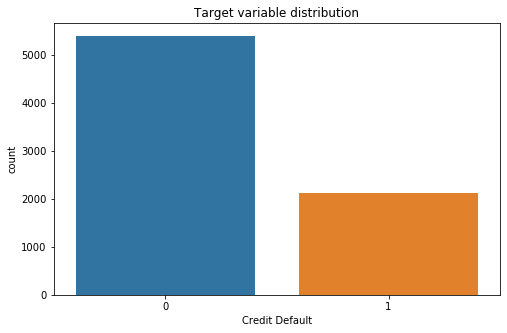

In [61]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

### **Корреляция с базовыми признаками**

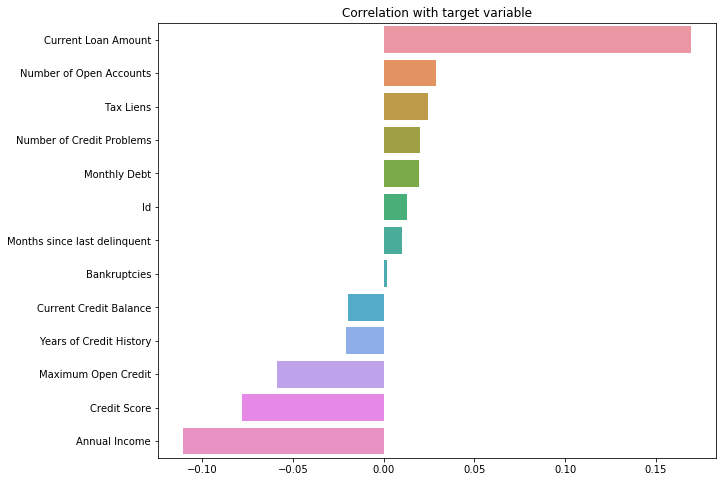

In [62]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### **Оценка признака "Number of Open Accounts" в разрезе целевой переменной**

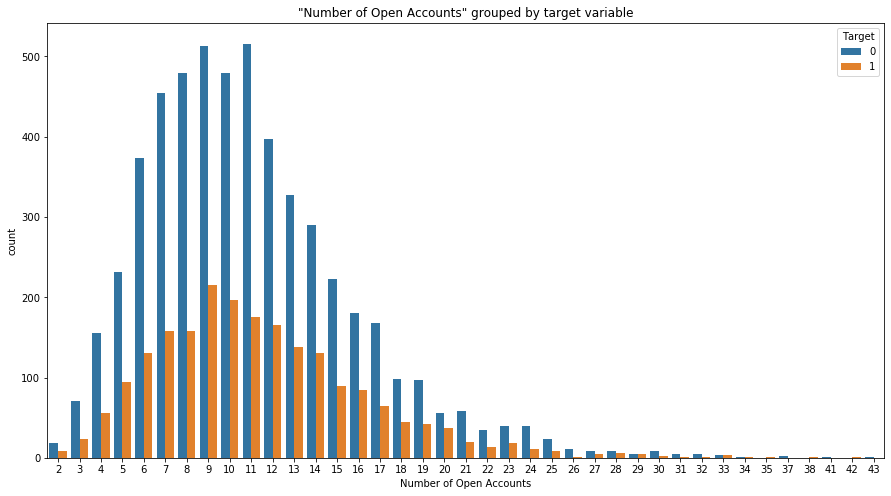

In [65]:
plt.figure(figsize=(15, 8))

sns.countplot(x="Number of Open Accounts", hue=TARGET_NAME, data=df_train)
plt.title('"Number of Open Accounts" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### *Сформируем выборку и рассчитаем наблюдаемые частоты*

In [66]:
# NOOA_and_target_s = df_train.loc[df_train['Number of Open Accounts'].isin([9, 10, 11]), ['Id', 'Number of Open Accounts', TARGET_NAME]].sample(1000)

In [67]:
# table = NOOA_and_target_s.pivot_table(values='Id', index='Number of Open Accounts', columns=TARGET_NAME, aggfunc='count')
# table

#### *Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона*

In [68]:
# chi2, p, dof, expected = chi2_contingency(table, correction=False)
# p

### **Оценка признака "Current Loan Amount" в разрезе целевой переменной**

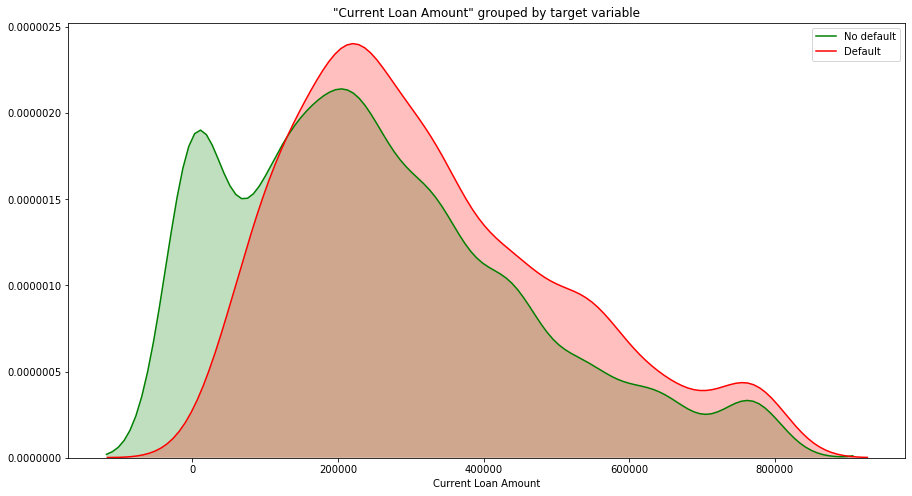

In [82]:
CLA_with_target_s = df_train[['Current Loan Amount', TARGET_NAME]].sample(5000)
CLA_s = CLA_with_target_s['Current Loan Amount']
CLA_target_0 = CLA_s[CLA_with_target_s[TARGET_NAME] == 0]
CLA_target_1 = CLA_s[CLA_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(15, 8))

sns.kdeplot(CLA_target_0, shade=True, label='No default', color='g')
sns.kdeplot(CLA_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('"Current Loan Amount" grouped by target variable')
plt.show()

#### *Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [83]:
shapiro(CLA_s)

(0.947352945804596, 5.001925059318184e-39)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

#### *Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

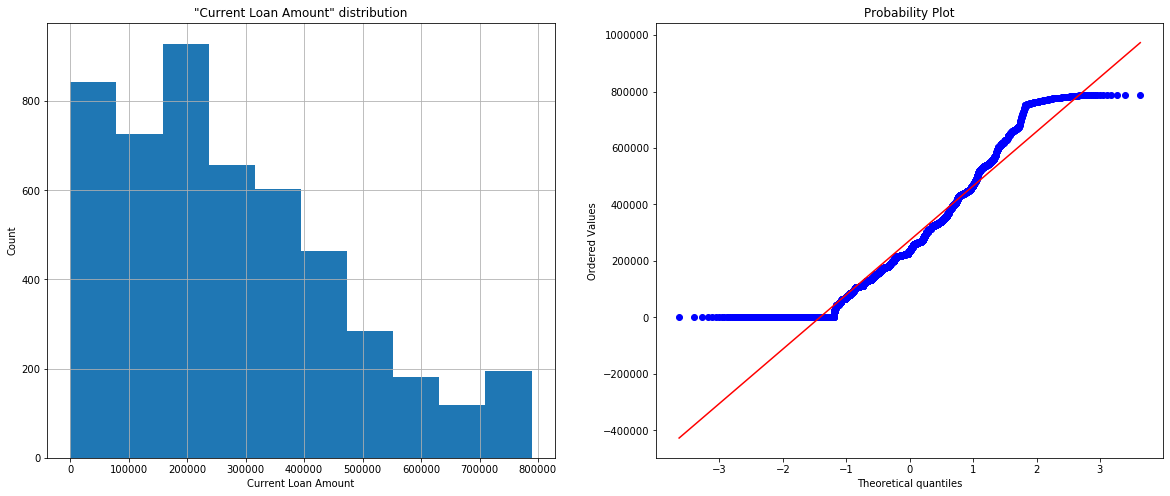

In [84]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('"Current Loan Amount" distribution')
CLA_s.hist()

plt.subplot(122)
probplot(CLA_s, dist='norm', plot=plt)

plt.show()

#### *Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [85]:
mannwhitneyu(CLA_target_0, CLA_target_1)

MannwhitneyuResult(statistic=1970388.5, pvalue=1.0070756886343254e-34)

Согласно значению p-value, гипотеза о равности мат. ожиданий НЕ принимается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

#### *Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

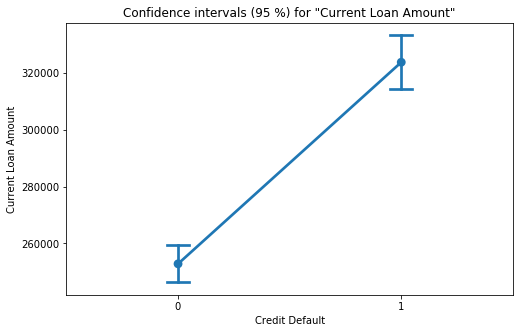

In [86]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=CLA_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for "Current Loan Amount"')
plt.show()

## Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

### **Матрица корреляций**

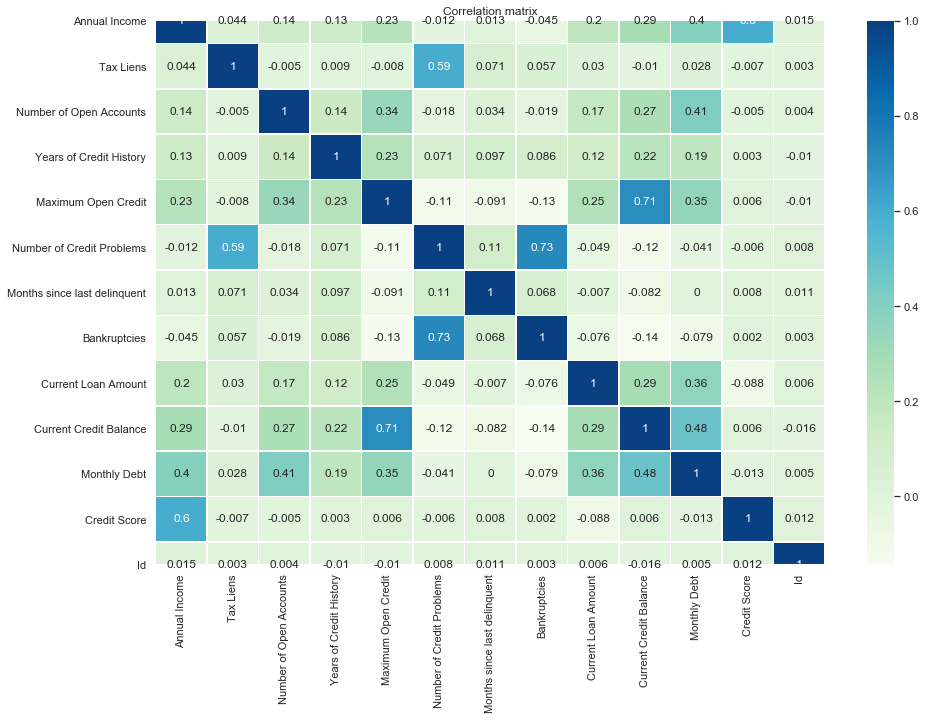

In [87]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.0)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Отбор признаков<a class="anchor" id="feature_selection"></a>

In [131]:
NUMERIC_FEATURE_NAMES = [
                         'Annual Income',
                         'Years of Credit History',
                         'Maximum Open Credit',
                         'Current Loan Amount',
                         'Current Credit Balance',
                         'Monthly Debt',
                         'Credit Score',
    
                         'Tax Liens',
                         'Number of Open Accounts',
                         'Number of Credit Problems',
                         'Months since last delinquent',
                         'Bankruptcies'                        ]

CAT_FEATURE_NAMES = [
                     'Home Ownership',
                     'Years in current job',
                     'Purpose',
                     'Term'
                    ]

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + CAT_FEATURE_NAMES

categ_feat_idx = np.arange(len(NUMERIC_FEATURE_NAMES), len(FEATURE_NAMES_SELECTED))
categ_feat_idx

array([12, 13, 14, 15])

## Нормализация данных<a class="anchor" id="normalization"></a>

In [173]:
scaler = StandardScaler()

In [174]:
df_train_norm = df_train.copy()
df_train_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUMERIC_FEATURE_NAMES])
df_train_norm.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7500.000000,7500.000000
mean,2.582823e-16,-4.879911e-16,8.967641e-17,-1.913728e-16,8.085014e-17,1.222888e-15,-3.812358e-16,-1.917873e-16,-3.241851e-17,3.139132e-17,-1.146638e-16,1.036800e-16,0.281733,3749.500000
std,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,0.449874,2165.207842
min,-1.164648e+00,-1.109534e-01,-1.860192e+00,-2.033305e+00,-9.540917e-01,-3.409789e-01,-6.983066e-01,-3.370990e-01,-1.380382e+00,-9.118548e-01,-1.558252e+00,-1.947276e+00,0.000000,0.000000
25%,-5.909683e-01,-1.109534e-01,-6.378469e-01,-6.841558e-01,-5.399916e-01,-3.409789e-01,-6.983066e-01,-3.370990e-01,-7.251897e-01,-5.523883e-01,-6.992581e-01,3.267651e-01,0.000000,1874.750000
50%,-9.955515e-02,-1.109534e-01,-2.303985e-01,-1.871009e-01,-2.449854e-01,-3.409789e-01,-6.983066e-01,-3.370990e-01,-1.790528e-01,-2.532962e-01,-1.866134e-01,5.142798e-01,0.000000,3749.500000
75%,4.505953e-01,-1.109534e-01,5.844983e-01,4.945743e-01,2.183150e-01,-3.409789e-01,5.821636e-01,-3.370990e-01,6.253256e-01,2.220323e-01,4.713371e-01,5.688295e-01,1.000000,5624.250000
max,8.892159e+00,2.566362e+01,6.492500e+00,5.592937e+00,1.319551e+01,1.369933e+01,4.511882e+00,1.119423e+01,2.606632e+00,1.955941e+01,6.647903e+00,6.131512e-01,1.000000,7499.000000


In [175]:
df_test_norm = df_test.copy()
df_test_norm[NUMERIC_FEATURE_NAMES] = scaler.transform(df_test_norm[NUMERIC_FEATURE_NAMES])
df_test_norm.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000
mean,-0.010722,0.018656,0.010892,0.001201,0.020346,-0.016046,-0.008884,-0.029213,0.012846,0.020649,0.000722,0.004997,8749.50000
std,0.954343,1.422355,0.988628,1.030275,1.029364,1.123012,0.998605,1.029153,1.006247,1.190190,0.984964,0.995382,721.83216
min,-1.164648,-0.110953,-2.063916,-2.047506,-0.954092,-0.340979,-0.698307,-0.337099,-1.380382,-0.911855,-1.550317,-1.947276,7500.00000
25%,-0.594048,-0.110953,-0.637847,-0.698357,-0.540946,-0.340979,-0.698307,-0.337099,-0.751092,-0.565420,-0.702906,0.330174,8124.75000
50%,-0.091852,-0.110953,-0.230398,-0.187101,-0.244406,-0.340979,-0.698307,-0.337099,-0.081226,-0.259393,-0.138256,0.514280,8749.50000
75%,0.436145,-0.110953,0.584498,0.537179,0.228258,-0.340979,0.493855,-0.337099,0.635247,0.240727,0.501968,0.565420,9374.25000
max,8.703819,55.120285,7.511121,4.982270,11.938940,29.745393,2.922333,14.077056,2.606965,18.059620,6.424184,0.613151,9999.00000


## Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [176]:
X = df_train_norm[FEATURE_NAMES_SELECTED]
y = df_train_norm[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

y_train.value_counts()[0]/y_train.value_counts()[1], y_test.value_counts()[0]/y_test.value_counts()[1]

(2.5623812539582014, 2.5112359550561796)

## Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

#### Для выбранной модели *CatBoost* балансировка задается в параметрах модели через веса классов

In [ ]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
# df_balanced[TARGET_NAME].value_counts()

In [ ]:
# X_train = df_balanced.drop(columns=TARGET_NAME)
# y_train = df_balanced[TARGET_NAME]

## Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [177]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                      class_weights=[1, 2.55],
                                      task_type='GPU', devices='0')

model_catb.fit(X_train, y_train
               , cat_features=categ_feat_idx
              )

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      4046
           1       0.56      0.77      0.65      1579

    accuracy                           0.77      5625
   macro avg       0.73      0.77      0.74      5625
weighted avg       0.80      0.77      0.78      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1341
           1       0.47      0.63      0.54       534

    accuracy                           0.69      1875
   macro avg       0.65      0.68      0.66      1875
weighted avg       0.73      0.69      0.71      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               965  376
1               197  337


In [178]:
y_train_pred_probs = model_catb.predict_proba(X_train)
y_train_pred = np.array((y_train_pred_probs[:,1] >= 0.55), dtype=float)

y_test_pred_probs = model_catb.predict_proba(X_test)
y_test_pred = np.array((y_test_pred_probs[:,1] >= 0.55), dtype=float)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4046
           1       0.64      0.66      0.65      1579

    accuracy                           0.80      5625
   macro avg       0.76      0.76      0.76      5625
weighted avg       0.80      0.80      0.80      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1341
           1       0.52      0.52      0.52       534

    accuracy                           0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1088  253
1                255  279


## Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [110]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')

### **Подбор гиперпараметров**

In [111]:
params = {'n_estimators':[100, 200, 500, 1000], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.005, 0.01, 0.05, 0.1],
#           'l2_leaf_reg':[1, 10, 100, 1000]
         }

In [112]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [113]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train
       , cat_features=categ_feat_idx
      )

Wall time: 1h 51min 16s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000021A31DE4C50>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [114]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.005}

In [115]:
rs.best_score_

0.5464901281294096

### **Обучение и оценка финальной модели**

In [116]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=5, learning_rate=0.005,
                                      silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')
final_model.fit(X_train, y_train
                , cat_features=categ_feat_idx
               )

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4046
           1       0.48      0.74      0.58      1579

    accuracy                           0.70      5625
   macro avg       0.68      0.72      0.68      5625
weighted avg       0.76      0.70      0.72      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1341
           1       0.45      0.69      0.54       534

    accuracy                           0.67      1875
   macro avg       0.64      0.67      0.64      1875
weighted avg       0.73      0.67      0.68      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               888  453
1               168  366
Wall time: 1min 42s


## Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [194]:
final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=5, learning_rate=0.005, l2_leaf_reg=1000,
                                      silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')
final_model.fit(X_train, y_train
                , cat_features=categ_feat_idx               
               )

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      4046
           1       0.45      0.71      0.55      1579

    accuracy                           0.67      5625
   macro avg       0.65      0.68      0.64      5625
weighted avg       0.74      0.67      0.69      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1341
           1       0.44      0.70      0.54       534

    accuracy                           0.66      1875
   macro avg       0.64      0.67      0.64      1875
weighted avg       0.73      0.66      0.68      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               869  472
1               162  372


## Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [132]:
final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=5, learning_rate=0.005, l2_leaf_reg=1000,
                                      cat_features=categ_feat_idx,  
                                      silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')

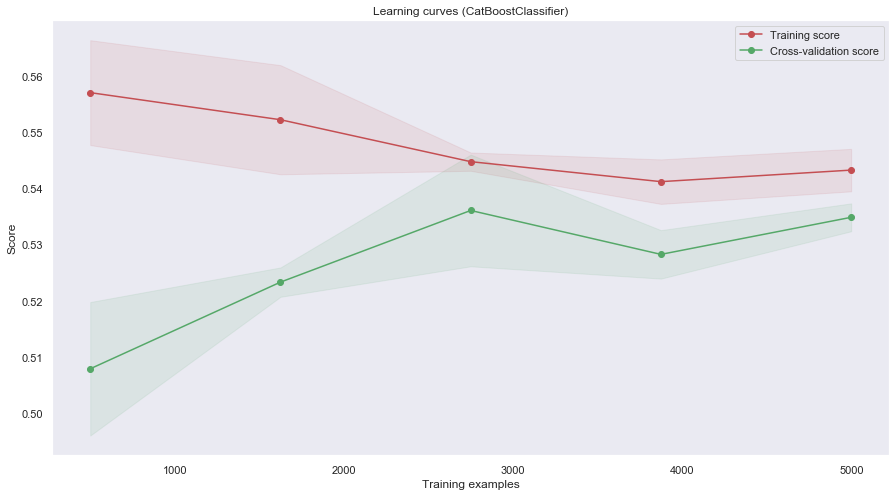

In [133]:
show_learning_curve_plot(final_model, X, y)

## Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

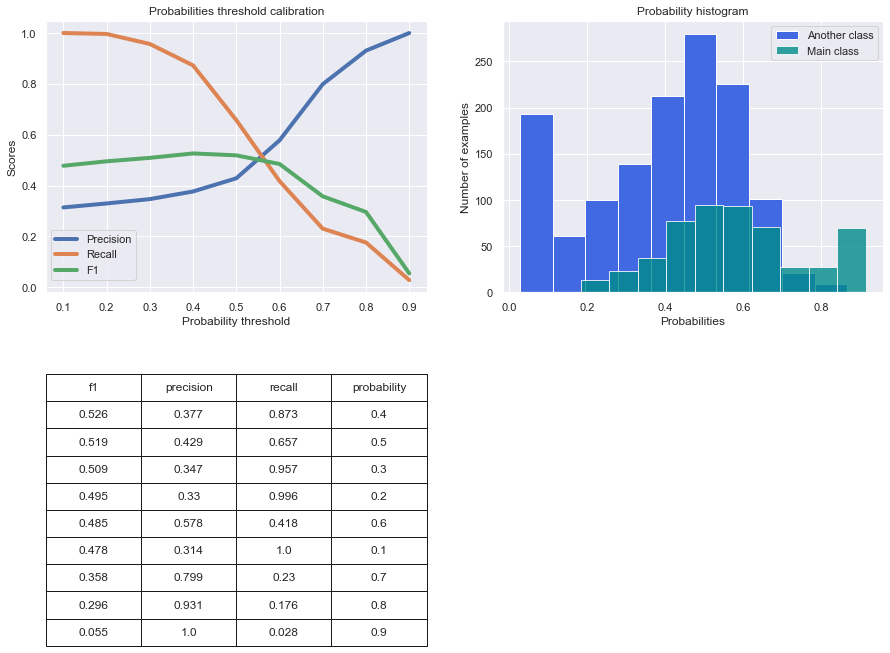

In [134]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

## Важность признаков<a class="anchor" id="feature_importances"></a>

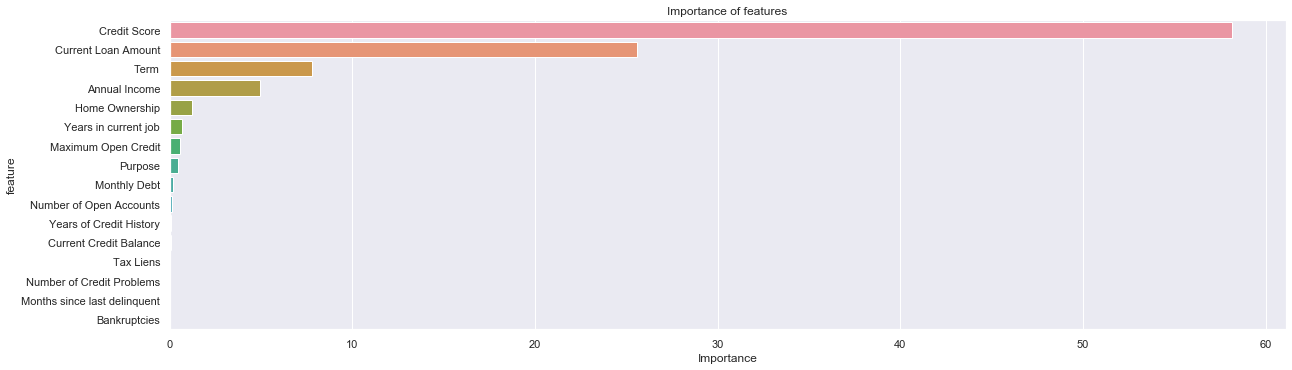

In [196]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

In [197]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Home Ownership',
 'Years in current job',
 'Maximum Open Credit',
 'Purpose',
 'Monthly Debt',
 'Number of Open Accounts']

In [137]:
idx = []
for i in important_features_top:
    if i in CAT_FEATURE_NAMES:
        idx.append(important_features_top.index(i))
categ_feat_idx = np.array(idx, dtype=np.int64)
categ_feat_idx

array([], dtype=int64)

## Финальная модель<a class="anchor" id="final_model"></a>

In [138]:
final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=5, learning_rate=0.005, l2_leaf_reg=1000,
                                      silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')
final_model.fit(X_train[important_features_top], y_train
                , cat_features=categ_feat_idx                 
               )

y_train_pred_probs = final_model.predict_proba(X_train[important_features_top])
y_train_pred = final_model.predict(X_train[important_features_top])

y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.57      0.69      4046
           1       0.41      0.76      0.53      1579

    accuracy                           0.63      5625
   macro avg       0.64      0.67      0.61      5625
weighted avg       0.73      0.63      0.65      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.58      0.69      1341
           1       0.41      0.72      0.52       534

    accuracy                           0.62      1875
   macro avg       0.62      0.65      0.61      1875
weighted avg       0.72      0.62      0.64      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               783  558
1               148  386


In [139]:
y_train_pred_probs = final_model.predict_proba(X_train[important_features_top])
y_train_pred = np.array((y_train_pred_probs[:,1] >= 0.55), dtype=float)

y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])
y_test_pred = np.array((y_test_pred_probs[:,1] >= 0.55), dtype=float)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4046
           1       0.52      0.56      0.54      1579

    accuracy                           0.73      5625
   macro avg       0.67      0.68      0.68      5625
weighted avg       0.74      0.73      0.74      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1341
           1       0.51      0.53      0.52       534

    accuracy                           0.72      1875
   macro avg       0.66      0.66      0.66      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1067  274
1                250  284


### Тренировка по всему train и предсказание по test.

In [182]:
categ_feat_idx = np.arange(len(NUMERIC_FEATURE_NAMES), len(FEATURE_NAMES_SELECTED))
categ_feat_idx

sample_sub = pd.read_csv('sampleSubmission.csv', index_col='Id')

final_model_full_train = catb.CatBoostClassifier(n_estimators=10000,
#                                                 max_depth=5, learning_rate=0.005, l2_leaf_reg=1000,
                                      silent=True, random_state=21, class_weights=[1, 2.55], task_type='GPU', devices='0')
final_model_full_train.fit(X, y
                , cat_features=categ_feat_idx                 
               )

y_pred = final_model_full_train.predict(X)

df_test_pred = final_model_full_train.predict(df_test[FEATURE_NAMES_SELECTED])

get_classification_report(y, y_pred, sample_sub['Credit Default'], df_test_pred)

sample_sub['Credit Default'] = df_test_pred.astype(int)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      5387
           1       0.57      0.77      0.65      2113

    accuracy                           0.77      7500
   macro avg       0.73      0.77      0.74      7500
weighted avg       0.80      0.77      0.78      7500

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2500
         1.0       0.00      0.00      0.00         0

    accuracy                           0.94      2500
   macro avg       0.50      0.47      0.48      2500
weighted avg       1.00      0.94      0.97      2500

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               2338  162


### **Predict to file**

In [185]:
sample_sub.to_csv('SBarinov_predictions_with_Id.csv', encoding='utf-8')
sample_sub.to_csv('SBarinov_predictions.csv', index=False, encoding='utf-8')

### Предсказание по test с порогом вероятности P=0.55.

In [186]:
sample_sub = pd.read_csv('sampleSubmission.csv', index_col='Id')

y_pred_probs = final_model_full_train.predict_proba(X)
y_pred = np.array((y_pred_probs[:,1] >= 0.55), dtype=float)

df_test_pred_probs = final_model_full_train.predict_proba(df_test_norm[FEATURE_NAMES_SELECTED])
df_test_pred = np.array((df_test_pred_probs[:,1] >= 0.55), dtype=float)

get_classification_report(y, y_pred, sample_sub['Credit Default'], df_test_pred)

sample_sub['Credit Default'] = df_test_pred.astype(int)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5387
           1       0.64      0.65      0.64      2113

    accuracy                           0.80      7500
   macro avg       0.75      0.75      0.75      7500
weighted avg       0.80      0.80      0.80      7500

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83      2500
         1.0       0.00      0.00      0.00         0

    accuracy                           0.71      2500
   macro avg       0.50      0.36      0.42      2500
weighted avg       1.00      0.71      0.83      2500

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1783  717


### **Predict_P=0.55 to file**

In [187]:
sample_sub.to_csv('SBarinov_predictions_with_Id_P_0_55.csv', encoding='utf-8')
sample_sub.to_csv('SBarinov_predictions_P_0_55.csv', index=False, encoding='utf-8')

## Сохранение модели<a class="anchor" id="saving_model"></a> 

### **Scaler**

In [188]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### **Model**

In [189]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model_full_train, file)

### **Train**

In [190]:
df_train.to_csv(PREP_TRAIN_DATASET_PATH , index=False, encoding='utf-8')

### **Test and predict**

In [191]:
df_test.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')